# 불균형 데이터 처리 - 소수 클래스 제거
- disgusted 클래스 제거
- batch_size: 64 -> 128로 증가
- epoch: 60 -> 180

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip -qq '/content/drive/MyDrive/team_project(DL)/DATA/emotion.zip' -d '/content/drive/MyDrive/team_project(DL)/DATA/emotion_remove'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

In [4]:
train_dir = "/content/drive/MyDrive/team_project(DL)/DATA/emotion_remove/train" #passing the path with training images
test_dir = "/content/drive/MyDrive/team_project(DL)/DATA/emotion_remove/test"   #passing the path with testing images

In [5]:
img_size = 48 #original size of the image

In [6]:
# 이미지 조회 함수
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

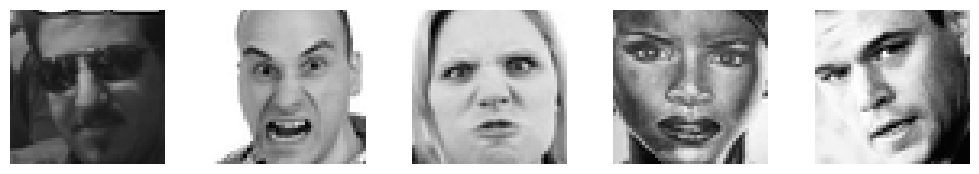

In [7]:
plot_images(train_dir+'/angry')

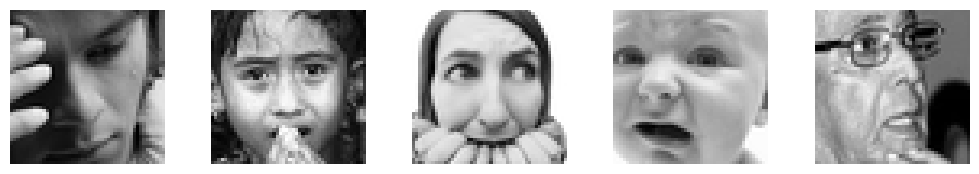

In [8]:
plot_images(train_dir+'/fearful')

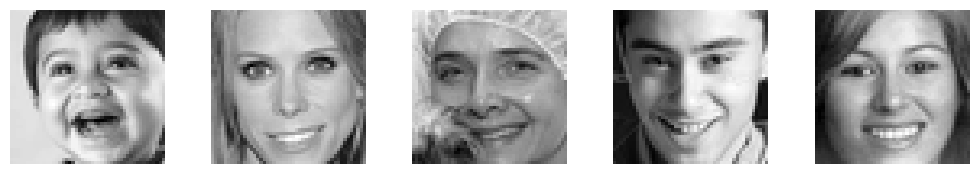

In [9]:
plot_images(train_dir+'/happy')

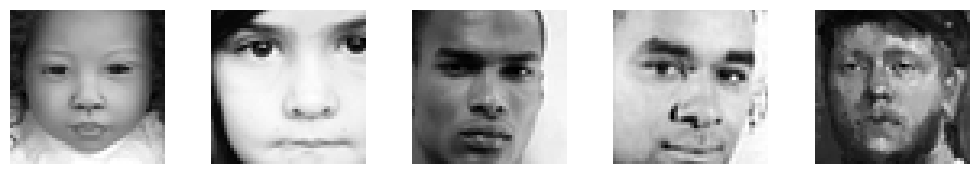

In [10]:
plot_images(train_dir+'/neutral')

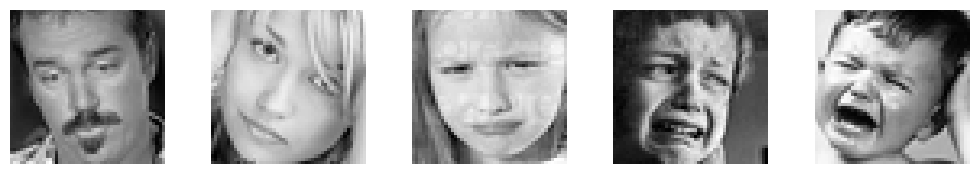

In [11]:
plot_images(train_dir+'/sad')

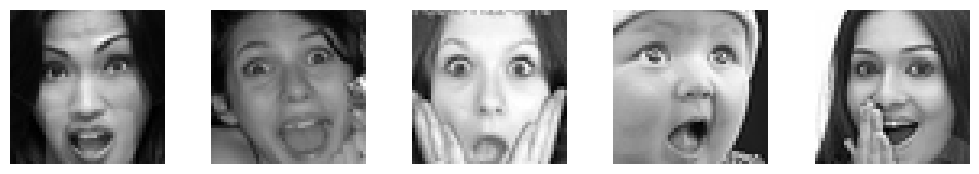

In [12]:
plot_images(train_dir+'/surprised')

In [13]:
# 컬럼 분포 조회 함수
def plot_bar_chart_diagram(path_data):
  dic={}
  for emotion in  os.listdir(path_data):
    dem=0
    for x in os.listdir(path_data+"/"+emotion):
      dem+=1
    dic[emotion]=dem
  print(dic)
  barlist=plt.bar(range(len(dic)), list(dic.values()),tick_label=list(dic.keys()))
#set color
  plt.show()

{'angry': 3995, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


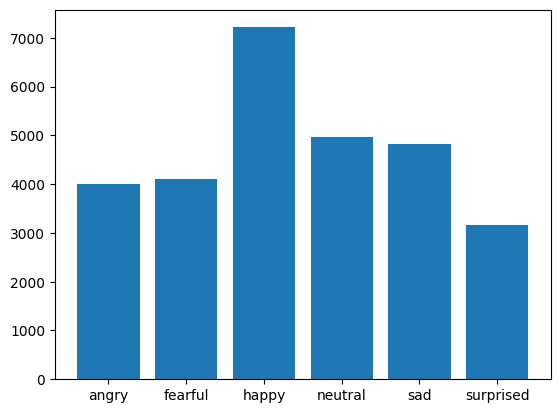

In [14]:
# TRAIN 이미지 분포 조회
plot_bar_chart_diagram(train_dir)

{'angry': 958, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


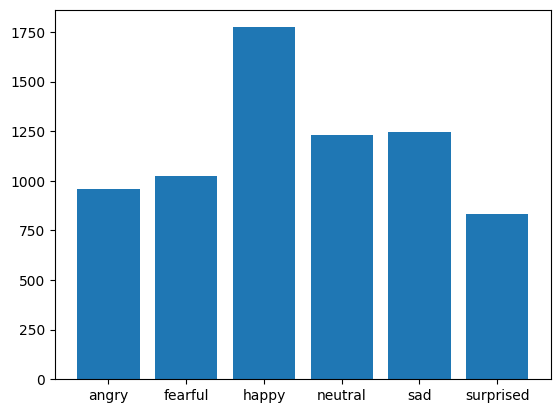

In [15]:
# TEST 이미지 분포 조회
plot_bar_chart_diagram(test_dir)

In [16]:
# 이미지 전처리(ImageDataGenerator)
# 데이터를 불러오는 동시에 여러가지 전처리를 쉽게 구현해주는 tf.keras 기능
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(#rotation_range = 180,  # 이미지 회전
                                         width_shift_range = 0.1,   # 이미지 너비를 따라 오른쪽 혹은 왼쪽으로 무작위 이동
                                         height_shift_range = 0.1,  # 이미지 높이를 따라 위 혹은 아래로 무작위 이동
                                         horizontal_flip = True,    # 이미지 수평으로 뒤집기(가로축 랜덤 설정)
                                         rescale = 1./255,          # 이미지의 픽셀값을 0에서 1사이로 축
                                        #  #zoom_range = 0.2,         # 무작위로 축소/확대 적용
                                        #  validation_split = 0.2     # 유효성 검사를 목적으로 사용할 일부 이미지 예약
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,           # validation에도 이미지 전처리 적용
                                        #  validation_split = 0.2
                                        )


In [17]:
"""
이미지를 불러올 때 이미지 증대 적용
Applying data augmentation to the images as we read
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 128, # 기존 64에서 128로 증가
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                #     subset = "training"  # ImageDataGenerator에 validation_split이 설정된 경우 데이터의 부분집합 ("training" or "validation").
                                                   )
validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 128, # 기존 64에서 128로 증가
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                            #   subset = "validation"   # ImageDataGenerator에 validation_split이 설정된 경우 데이터의 부분집합 ("training" or "validation").
                                                             )



Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


### batch_size
- 일반적으로 32, 64 크기의 mini-batch가 성능에는 가장 좋다고 알려져 있음
- batch size를 줄임으로써 얻는 장점: 필요한 메모리 감소
- batch size를 늘림으로써 얻는 장점: 학습이 안정적

In [18]:
"""
Modeling


model = Sequential()
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = 'same',activation = 'relu',input_shape=(img_size,img_size,1)))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256,kernel_size = (3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D(pool_size = 2,strides = 2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units = 128,activation = 'relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(units = 64,activation = 'relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units = 32,activation = 'relu',kernel_initializer='he_normal'))
model.add(Dense(7,activation = 'softmax'))

"""

"\nModeling\n\n\nmodel = Sequential()\nmodel.add(Conv2D(filters = 64,kernel_size = (3,3),padding = 'same',activation = 'relu',input_shape=(img_size,img_size,1)))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(filters = 128,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(filters = 256,kernel_size = (3,3),padding = 'same',activation = 'relu'))\nmodel.add(MaxPool2D(pool_size = 2,strides = 2))\nmodel.add(BatchNormalization())\n\nmodel.add(Flatten())\nmodel.add(Dense(units = 128,activation = 'relu',kernel_initializer='he_normal'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(units = 64,activation = 'relu'

In [19]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))  # 클래스 수 변경: 7 -> 6

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [20]:
epochs = 180      # 60 -> 180
batch_size = 128  # 64 -> 128

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [22]:
# 이전 학습이 중단된 지점부터 다시 시작할 수 있도록 현재 에포크를 저장하는 함수
def save_current_epoch(epoch):
    with open('current_epoch.txt', 'w') as f:
        f.write(str(epoch))

# 저장된 현재 에포크를 불러오는 함수
def load_current_epoch():
    try:
        with open('current_epoch.txt', 'r') as f:
            current_epoch = int(f.read().strip())
    except FileNotFoundError:
        current_epoch = 0
    return current_epoch

In [23]:
# 3가지 콜백(callback) 설정
lrd = ReduceLROnPlateau(monitor='val_accuracy', patience=20, verbose=1, factor=0.5, min_lr=1e-10)  # patience 체크
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/team_project(DL)/final/emotion_model_imbalanceremove_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [24]:
%%time
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lrd, es, mc]
)

Epoch 1/180
220/220 [==============================] - ETA: 0s - loss: 9.2069 - accuracy: 0.2082  
Epoch 1: val_accuracy improved from -inf to 0.25142, saving model to /content/drive/MyDrive/team_project(DL)/final/emotion_model_imbalanceremove_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 27092s 123s/step - loss: 9.2069 - accuracy: 0.2082 - val_loss: 8.5754 - val_accuracy: 0.2514 - lr: 1.0000e-04
Epoch 2/180
220/220 [==============================] - ETA: 0s - loss: 8.3407 - accuracy: 0.2374
Epoch 2: val_accuracy did not improve from 0.25142
220/220 [==============================] - 119s 542ms/step - loss: 8.3407 - accuracy: 0.2374 - val_loss: 7.8413 - val_accuracy: 0.2085 - lr: 1.0000e-04
Epoch 3/180
220/220 [==============================] - ETA: 0s - loss: 7.5523 - accuracy: 0.2537
Epoch 3: val_accuracy improved from 0.25142 to 0.27798, saving model to /content/drive/MyDrive/team_project(DL)/final/emotion_model_imbalanceremove_best.h5
220/220 [==============================] - 120s 547ms/step - loss: 7.5523 - accuracy: 0.2537 - val_loss: 7.1237 - val_accuracy: 0.2780 - lr: 1.0000e-04
Epoch 4/180
220/220 [==============================] - ETA: 0s - loss: 6.7493 - accuracy: 0.2825
Epoch 4: val_accuracy improved from 0.27798 t

In [25]:
# # 이전 학습이 중단된 지점부터 다시 시작할 수 있도록 현재 에포크를 불러옴
# current_epoch = load_current_epoch()

In [26]:
# %%time
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     initial_epoch=current_epoch,  # 현재 에포크로부터 다시 시작
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     callbacks=[lrd, es, mc],  # 콜백 함수 적용
# )

In [32]:
# 학습이 완료된 후 현재 에포크를 저장함
save_current_epoch(epochs)

---
# 모델 성능 평가

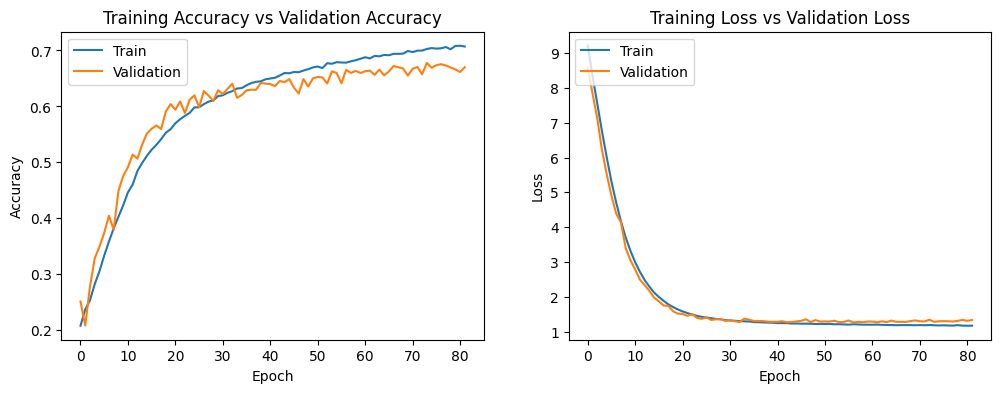

In [28]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [33]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

56/56 [==============================] - 20s 360ms/step - loss: 1.3389 - accuracy: 0.6703
final train accuracy = 75.08 , validation accuracy = 67.03


In [34]:
model.save_weights('/content/drive/MyDrive/team_project(DL)/final/emotion_model_removeclass_weights.h5')

---
# 이미지 예측

In [35]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}

# happy

1/1 [==============================] - 0s 19ms/step
[0.0044943406, 0.008237711, 0.11577001, 0.5504439, 0.31358463, 0.007469395]
Neutral


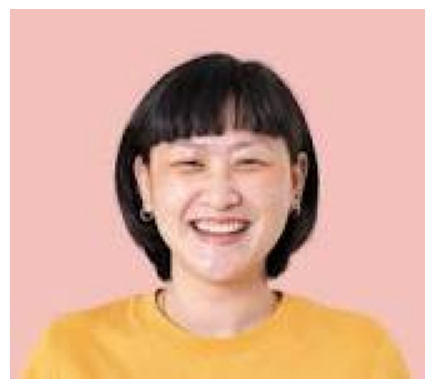

In [54]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/happy.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/happy.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# fear

1/1 [==============================] - 0s 17ms/step
[0.16354461, 0.45149475, 0.007980622, 0.07764079, 0.21796921, 0.08136997]
Fear


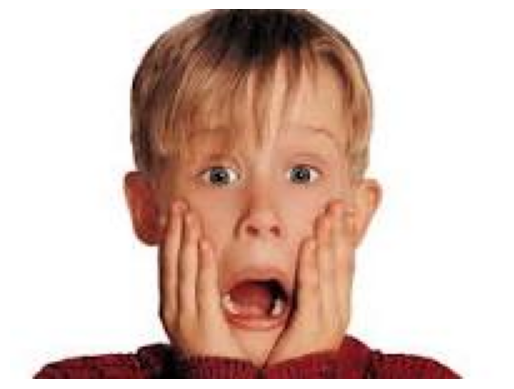

In [37]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/fear.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/fear.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# neutral

1/1 [==============================] - 0s 17ms/step
[0.028023774, 0.026192673, 0.0017649519, 0.8426952, 0.10029408, 0.0010293508]
Neutral


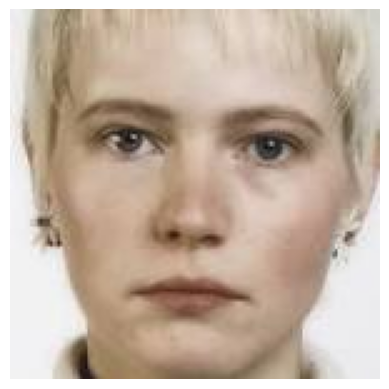

In [38]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/neutral face.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/neutral face.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# surprise

1/1 [==============================] - 0s 46ms/step
[0.1452444, 0.098409064, 0.006684759, 0.33848134, 0.3936213, 0.017559094]
Sad


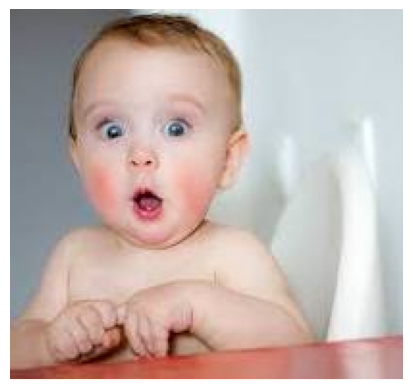

In [55]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/surprise face.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/surprise face.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# angry

1/1 [==============================] - 0s 17ms/step
[0.03273579, 0.17382361, 0.029843811, 0.026413053, 0.7301826, 0.0070010475]
Sad


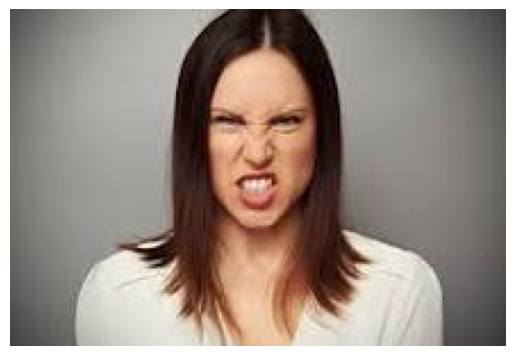

In [40]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/angry face.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/angry face.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# 송강

1/1 [==============================] - 0s 17ms/step
[0.0046478007, 0.03749219, 0.01066051, 0.034810588, 0.91169083, 0.00069803395]
Sad


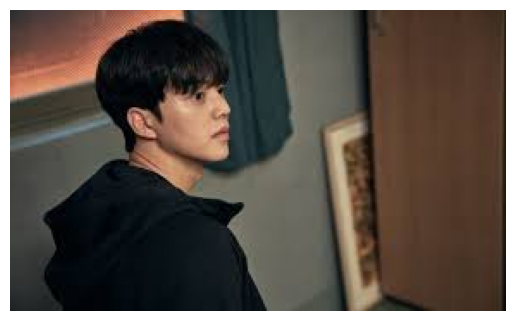

In [41]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/송강.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/송강.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# 유해진

1/1 [==============================] - 0s 17ms/step
[0.020733228, 0.0068624266, 0.35998058, 0.47559988, 0.13166665, 0.0051572314]
Neutral


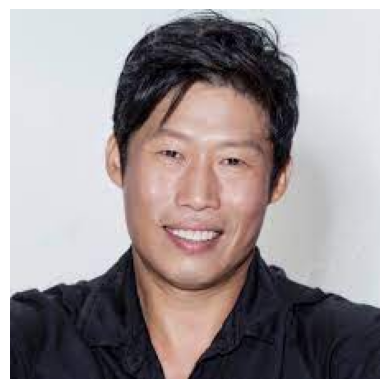

In [42]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/유해진.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/유해진.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# 카리나

1/1 [==============================] - 0s 18ms/step
[0.17288774, 0.14090905, 0.5309731, 0.0057674106, 0.114965074, 0.034497667]
Happy


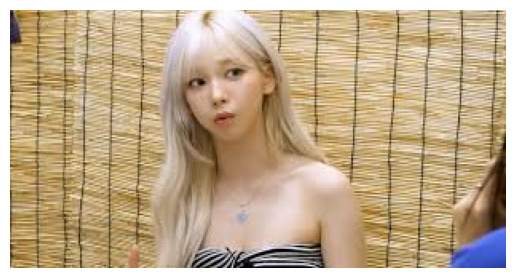

In [57]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/카리나.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/카리나.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


# 기타

1/1 [==============================] - 0s 17ms/step
[0.003520639, 0.023937682, 0.0041773706, 0.11654231, 0.8502207, 0.0016012802]
Sad


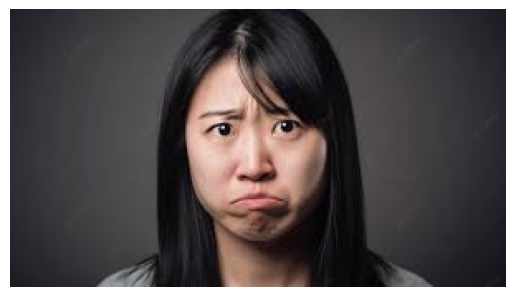

In [44]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/sadness.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/sadness.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 18ms/step
[0.11294272, 0.14608118, 0.2894756, 0.046939105, 0.35750452, 0.047056917]
Sad


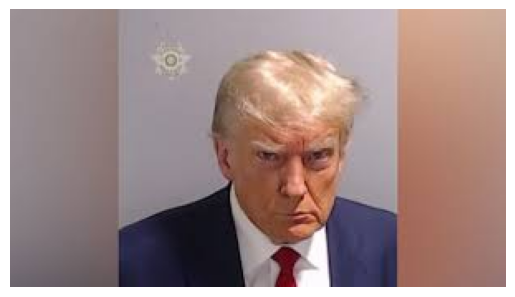

In [56]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/trump.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/trump.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 27ms/step
[0.12822025, 0.046117283, 0.2912469, 0.18133864, 0.3468817, 0.0061952267]
Sad


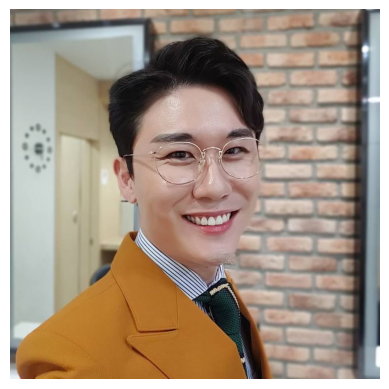

In [53]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/행복.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/행복.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 20ms/step
[0.0072865533, 0.008929673, 0.51728046, 0.2925884, 0.17285806, 0.0010568473]
Happy


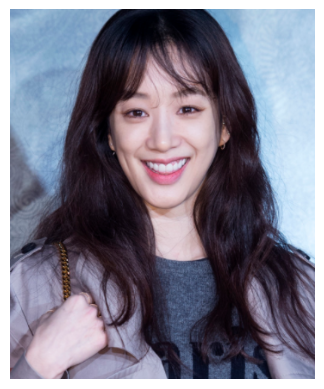

In [49]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/해피.png", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/해피.png")
plt.imshow(img_original)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 68ms/step
[0.14298591, 0.26995084, 0.16639549, 0.041963656, 0.31480786, 0.06389628]
Sad


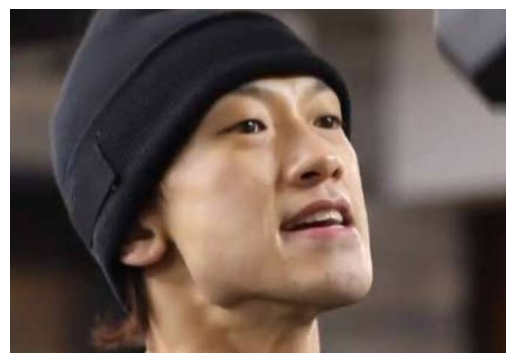

In [52]:
# 이미지 전처리 후의 이미지를 사용하여 결과 도출
img_preprocessed = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/비.jpg", target_size=(48, 48), color_mode='grayscale')
img_preprocessed = image.img_to_array(img_preprocessed)
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
img_preprocessed /= 255.0

result = model.predict(img_preprocessed)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print(label_dict[img_index])

# 원래의 이미지를 사용하여 시각화
img_original = image.load_img("/content/drive/MyDrive/team_project(DL)/DATA/비.jpg")
plt.imshow(img_original)
plt.axis('off')
plt.show()
